# Census Bureau Income Data - SHAP Analysis

This cleaned notebook consolidates imports, model loading, data preparation, and a single SHAP analysis flow. It removes duplicate imports, duplicate data-loading logic, and multiple SHAP attempts.

In [5]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import shap
from pathlib import Path
import re

# Create visualization directory
VIZ_DIR = Path('outputs/visualizations')
VIZ_DIR.mkdir(parents=True, exist_ok=True)

In [6]:
# Load the trained model (supports either a dict wrapper or a raw model/pipeline)
with open('../final_model.pkl', 'rb') as f:
    model_data = pickle.load(f)

# final_model.pkl may store a dict with keys or the model object directly
if isinstance(model_data, dict):
    model = model_data.get('model', model_data)
    stored_feature_names = model_data.get('feature_names')
    threshold = model_data.get('threshold')
else:
    model = model_data
    stored_feature_names = None
    threshold = None

print('Model loaded successfully')
if threshold is not None:
    print(f'Optimal threshold: {threshold:.4f}')

Model loaded successfully
Optimal threshold: 0.1900


Transforming features...
Data prepared successfully
X_transformed shape: (199523, 210)
Number of feature names: 210
Explaining 500 samples (background 50)


100%|██████████| 500/500 [04:43<00:00,  1.76it/s]


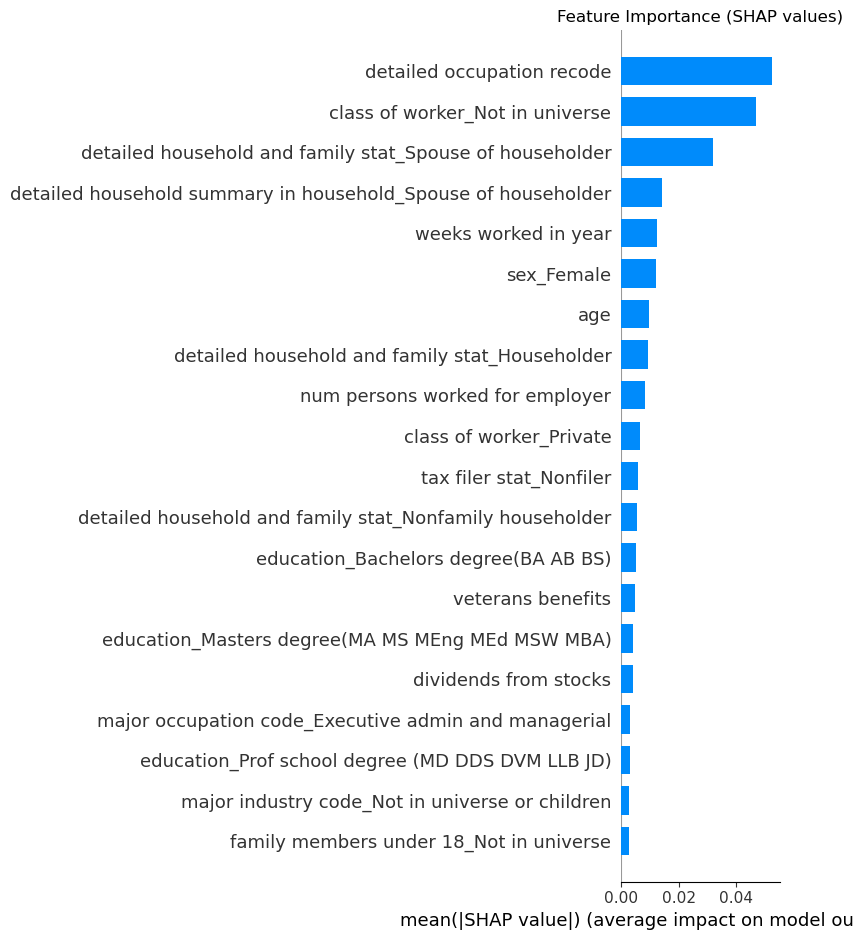

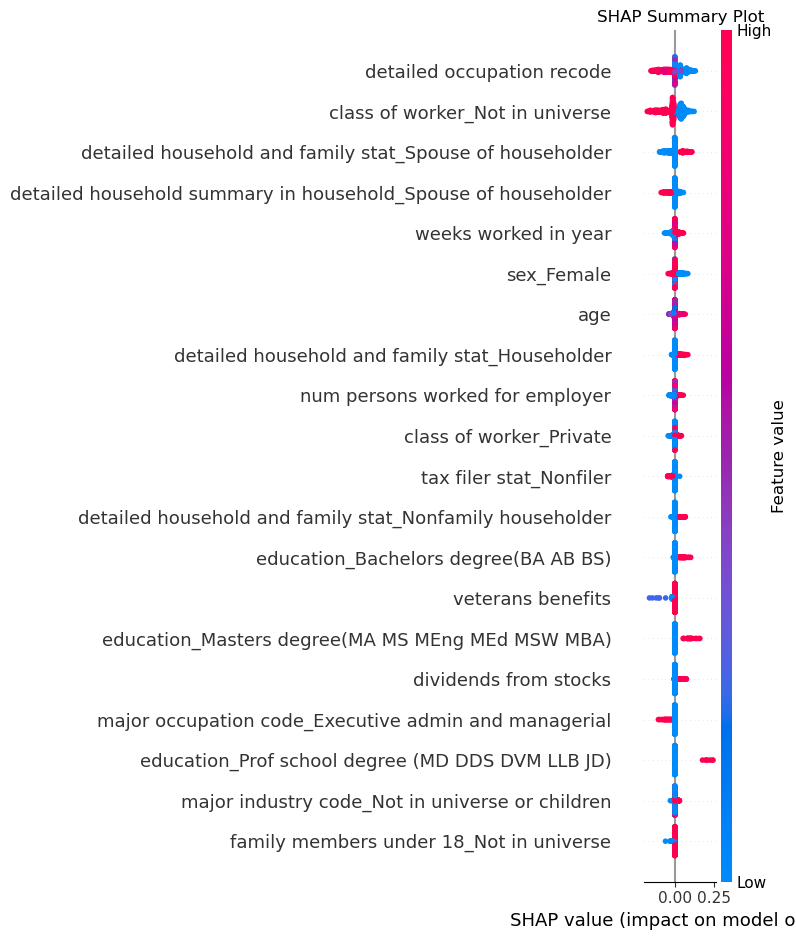

In [7]:
# Load and prepare the data (single canonical data-loading cell)
BASE_DIR = Path('..')
RAW_COLS_FILE = BASE_DIR / 'data' / 'census-bureau.columns'
RAW_DATA_FILE = BASE_DIR / 'data' / 'census-bureau.data'

# Read column names and data
cols = pd.read_csv(RAW_COLS_FILE, header=None, names=['col'])['col'].str.strip().tolist()
df = pd.read_csv(RAW_DATA_FILE, header=None, names=cols, sep=r'\s*,\s*', engine='python')

# Normalize and map target to binary
target_map = {'- 50000.': 0, ' - 50000.': 0, '50000+.': 1, ' 50000+.': 1}
def _norm_key(s):
    s = "" if pd.isna(s) else str(s)
    s = re.sub(r"\s+", " ", s).strip()
    return s
_target_map_norm = {_norm_key(k): v for k, v in target_map.items()}
df['label_bin'] = df['label'].map(lambda x: _target_map_norm.get(_norm_key(x), np.nan))
df = df.dropna(subset=['label_bin']).reset_index(drop=True)
df['label_bin'] = df['label_bin'].astype(int)

# Features and target
X = df.drop(columns=['label', 'label_bin'])
y = df['label_bin']

# Transform features using the model/pipeline preprocessor
# Support both pipeline.transform and explicit named_steps['prep'].transform
print('Transforming features...')
if hasattr(model, 'transform'):
    X_transformed = model.transform(X)
elif hasattr(model, 'named_steps') and 'prep' in getattr(model, 'named_steps'):
    X_transformed = model.named_steps['prep'].transform(X)
else:
    raise RuntimeError('Model does not expose a transform method or a named step')

# Convert sparse to dense once (document memory implications)
if hasattr(X_transformed, 'toarray'):
    X_transformed = X_transformed.toarray()

# Derive feature names if not provided by the stored model artifact
if stored_feature_names is not None:
    feature_names = stored_feature_names
else:
    feature_names = []
    if hasattr(model, 'named_steps') and 'prep' in getattr(model, 'named_steps'):
        for name, transformer, cols in model.named_steps['prep'].transformers_:
            if transformer == 'drop' or name == 'remainder':
                continue
            if hasattr(transformer, 'get_feature_names_out'):
                feature_names.extend(transformer.get_feature_names_out(cols))
            else:
                feature_names.extend(cols)

print('Data prepared successfully')
print(f'X_transformed shape: {X_transformed.shape}')
print(f'Number of feature names: {len(feature_names)}')

# Starting SHAP analysis...")

# Define a prediction function that accepts transformed data (array) and returns probabilities for the positive class
def predict_fn(x_array):
    # If model is a pipeline with a final calibrated classifier named 'cal', use that; otherwise try model.predict_proba
    if hasattr(model, 'named_steps') and 'cal' in getattr(model, 'named_steps'):
        clf = model.named_steps['cal']
        return clf.predict_proba(x_array)[:, 1]
    elif hasattr(model, 'predict_proba'):
        return model.predict_proba(x_array)[:, 1]
    else:
        # fallback to predict (may be 0/1 values)
        return model.predict(x_array)

# Choose explainer type: TreeExplainer when available, otherwise KernelExplainer
try:
    import sklearn.ensemble as _se
    is_tree_like = any([hasattr(getattr(model, 'estimators_', None), '__len__'), isinstance(getattr(model, 'named_steps', None), object) and False])
except Exception:
    is_tree_like = False

# Use KernelExplainer (works generally); keep background small to speed up computation
n_background = min(50, len(X_transformed))
background = shap.sample(X_transformed, n_background, random_state=42)
explainer = shap.KernelExplainer(predict_fn, background)

# Limit number of explanations to reasonable size
n_explain = min(500, len(X_transformed))
if len(X_transformed) > n_explain:
    rng = np.random.default_rng(42)
    idx = rng.choice(len(X_transformed), n_explain, replace=False)
    X_sample = X_transformed[idx]
else:
    X_sample = X_transformed

print(f'Explaining {X_sample.shape[0]} samples (background {background.shape[0]})')
shap_values = explainer.shap_values(X_sample)

# Save a bar summary (mean absolute) and the standard SHAP summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values if not isinstance(shap_values, list) else shap_values, X_sample, feature_names=feature_names, plot_type='bar', show=False)
plt.title('Feature Importance (SHAP values)')
plt.tight_layout()
plt.savefig(VIZ_DIR / 'shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values if not isinstance(shap_values, list) else shap_values, X_sample, feature_names=feature_names, show=False)
plt.title('SHAP Summary Plot')
plt.tight_layout()
plt.savefig(VIZ_DIR / 'shap_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

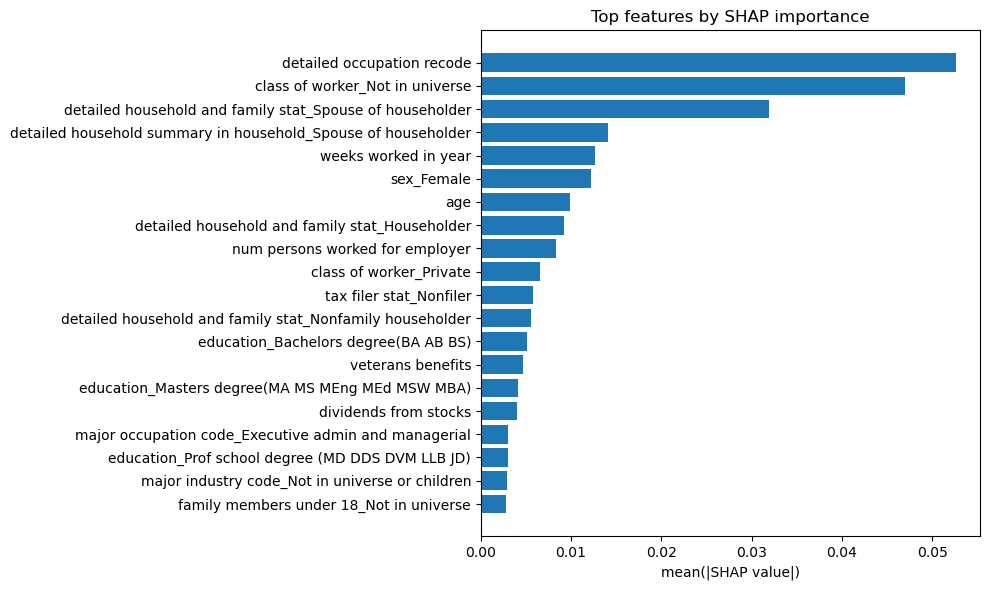


Top 20 Most Important Features:
                                              feature  importance
0                          detailed occupation recode    0.052667
1                     class of worker_Not in universe    0.047036
2   detailed household and family stat_Spouse of h...    0.031924
3   detailed household summary in household_Spouse...    0.014124
4                                weeks worked in year    0.012623
5                                          sex_Female    0.012176
6                                                 age    0.009857
7      detailed household and family stat_Householder    0.009237
8                     num persons worked for employer    0.008375
9                             class of worker_Private    0.006514
10                            tax filer stat_Nonfiler    0.005820
11  detailed household and family stat_Nonfamily h...    0.005517
12               education_Bachelors degree(BA AB BS)    0.005135
13                                  veteran

In [8]:
# Compute mean absolute SHAP importances and show top features
shap_arr = shap_values if not isinstance(shap_values, list) else shap_values[0] if len(shap_values) == 1 else shap_values[1]
shap_importance = np.abs(shap_arr).mean(axis=0)
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': shap_importance})
feature_importance = feature_importance.sort_values('importance', ascending=False).reset_index(drop=True)

# Plot top 20 features
top_n = min(20, len(feature_importance))
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'].head(top_n)[::-1], feature_importance['importance'].head(top_n)[::-1])
plt.xlabel('mean(|SHAP value|)')
plt.title('Top features by SHAP importance')
plt.tight_layout()
plt.savefig(VIZ_DIR / 'feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Print top 20 most important features
print('\nTop 20 Most Important Features:')
print(feature_importance.head(20))